# Signal Modulation classification 3
Experiment with architecture and data

**References**:
- [Original SIM2](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)
- [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/pdf/1602.04105.pdf)
- [Automatic Signal Modulation Recognition based on Deep Convolutional Neural Network](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi8gNXSl5b9AhWn-yoKHRtdCGUQFnoECBIQAQ&url=https%3A%2F%2Fwww.atlantis-press.com%2Farticle%2F125913178.pdf&usg=AOvVaw1NhM3rX7_Ve6yQoFJlmecP)

Mixed dataset v1 - snr in [0..30] with step 5. 2k samples per modulation

## Imports

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple

sys.path.append("..") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [4]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = True
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "../data/RML2016.10a/RML2016.10a_dict.pkl"
TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_2k_SNR_0-30"

# Deployment
# model_name = "simc_2_mixed_0-30_data"
model_name = "simc_2_radioML_a"
# MODELS_DIR = f'models_{model_name}_MIXED_0-30_DATA/'
MODELS_DIR = f'models_{model_name}_RADIO_ML_A/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
snrs = [0, 5, 10, 15, 20, 25, 30]


Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
reload_module("tools.data")
from tools.data import load_data_simc_v1
# labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR)
# labels, data = load_data_simc_v1(
#     classes=modulations, 
#     path=Path(TRAIN_DATA_DIR), 
#     model_dtype=MODEL_DATA_TYPE
# )

snr_to_labels_data = {}
for snr in snrs:
    print(f"snr={snr}")
    labels, data = load_data_simc_v1(
        classes=modulations, 
        path=Path(TRAIN_DATA_DIR) / f"train_data_SIMC1_2k_SNR_{snr}", 
        model_dtype=MODEL_DATA_TYPE
    )
    snr_to_labels_data[snr] = (labels, data)


snr=0
[debug] Loaded train data with size 22528000 in 8.441895961761475s
snr=5
[debug] Loaded train data with size 22528000 in 8.611241340637207s
snr=10
[debug] Loaded train data with size 22528000 in 8.5621337890625s
snr=15
[debug] Loaded train data with size 22528000 in 8.794541835784912s
snr=20
[debug] Loaded train data with size 22528000 in 8.636870384216309s
snr=25
[debug] Loaded train data with size 22528000 in 8.719839572906494s
snr=30
[debug] Loaded train data with size 22528000 in 8.273739337921143s


In [6]:
# print(modulations)
# print(labels.shape)
# print(data.shape)

['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(22000,)
(22000, 1, 1024, 2)


### Data preprocessing

In [7]:
# classes = list(set(map(lambda v: v[0].decode("utf-8"), crmrn_ds_keys)))
# print(classes)
# print(len(classes))
# class_name_to_class_idx = {name: idx for idx, name in enumerate(classes)}
# print(class_name_to_class_idx)

In [8]:
# ds_size = 220 * 1000 // 8
# data = np.empty((ds_size, 1, 1024, 2))
# labels = np.empty((ds_size,), dtype=np.uint8)


# cur_idx = 0
# for (class_name, snr), raw_data in crmrn_ds.items():
#     str_class_name = class_name.decode("utf-8")
#     for frame_idx in range(0, len(raw_data), 8):
#         frame_1024 = np.hstack([raw_data[idx] for idx in range(frame_idx, frame_idx+8)])
#         data[cur_idx] = frame_1024.reshape((1, 1024, 2))
#         labels[cur_idx] = class_name_to_class_idx[str_class_name]
#         cur_idx += 1
    

In [9]:
snr_to_labels_data_train = {}
snr_to_labels_data_validation = {}
snr_to_labels_data_test = {}

for snr in snrs:
    labels, data = snr_to_labels_data[snr]
    SIZE = len(labels)

    n_train = int(0.8 * SIZE)
    n_validation = int(0.1 * SIZE)
    n_test = SIZE - n_train - n_validation

    random_indecies = np.arange(SIZE)
    np.random.shuffle(random_indecies)

    train_indecies, validation_indecies, test_indecies, _ = np.split(
        random_indecies, [int(SIZE * 0.8), int(SIZE * 0.9), SIZE]
    )

    train_data, train_labels = data[train_indecies], labels[train_indecies]
    validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
    test_data, test_labels = data[test_indecies], labels[test_indecies]

    snr_to_labels_data_train[snr] = (train_labels, train_data)
    snr_to_labels_data_validation[snr] = (validation_labels, validation_data)
    snr_to_labels_data_test[snr] = (test_labels, test_data)


In [10]:
train_data = []
train_labels = []
validation_data = []
validation_labels = []
for snr in snrs:
    train_data.append(snr_to_labels_data_train[snr][1])
    train_labels.append(snr_to_labels_data_train[snr][0])

    validation_data.append(snr_to_labels_data_validation[snr][1])
    validation_labels.append(snr_to_labels_data_validation[snr][0])
print(train_data[0].shape)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

(17600, 1, 1024, 2)


In [11]:
print(train_data.shape)
print(validation_data.shape)
print(train_labels.shape)
print(validation_labels.shape)

(123200, 1, 1024, 2)
(15400, 1, 1024, 2)
(123200,)
(15400,)


There are 27_500 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [14]:
# Should save some memory
del data
del labels

## Model creation


In [17]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

def create_model_simc_2():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_simc_3_stable():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model



In [18]:
model = create_model_simc_3()
model.summary()

(None, 1, 1024, 2)
(None, 1, 2, 1024)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 permute_1 (Permute)         (None, 1, 2, 1024)        0         
                                                                 
 CNN1_ (Conv2D)              (None, 32, 2, 1024)       288       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 32, 2, 1024)       4096      
                                                                 
 re_lu_4 (ReLU)              (None, 32, 2, 1024)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 2, 512)       0         
 2D)                                                             
                       

In [19]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)



In [20]:
def step_decay(epoch):
    lrate = 0.02
    factor = epoch // 9
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# N_EPOCHS = 16 
# BATCH_SIZE = 256
N_EPOCHS = 20
BATCH_SIZE = 256
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


Epoch 1/20
482/482 [==============================] - 70s 134ms/step - loss: 14.6299 - accuracy: 0.0906 - val_loss: 14.6235 - val_accuracy: 0.0927 - lr: 0.0200
Epoch 2/20
482/482 [==============================] - 64s 133ms/step - loss: 14.6592 - accuracy: 0.0905 - val_loss: 14.6235 - val_accuracy: 0.0927 - lr: 0.0200
Epoch 3/20
482/482 [==============================] - 64s 133ms/step - loss: 14.6592 - accuracy: 0.0905 - val_loss: 14.6235 - val_accuracy: 0.0927 - lr: 0.0200
Epoch 4/20
482/482 [==============================] - 65s 134ms/step - loss: 14.6592 - accuracy: 0.0905 - val_loss: 14.6235 - val_accuracy: 0.0927 - lr: 0.0200
Epoch 5/20
 73/482 [===>..........................] - ETA: 53s - loss: 14.6424 - accuracy: 0.0916

KeyboardInterrupt: 

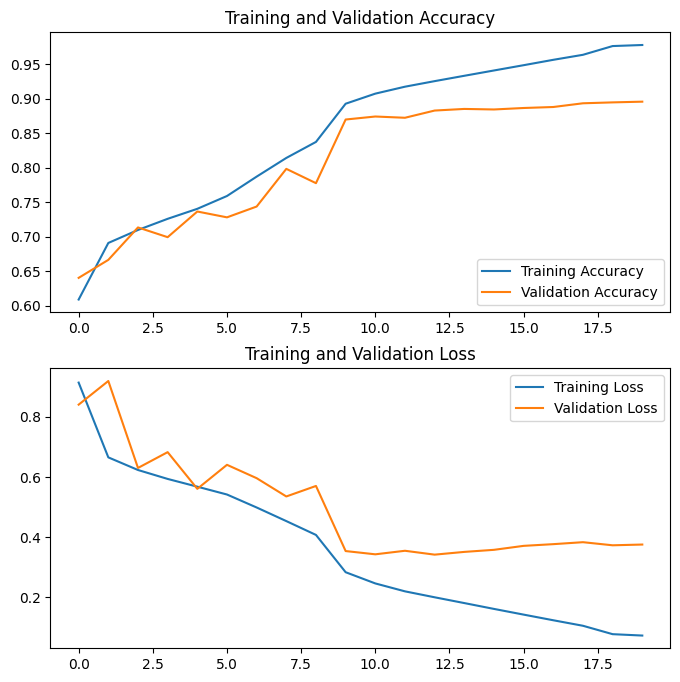

In [35]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [66]:
test_preds = model.predict(test_data)

69/69 [==============================] - 1s 5ms/step


In [67]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[6 1 3 5 0 4 8 0 2 6]
[6 0 3 5 0 4 8 0 2 6]


Overall test accuracy: 0.8663636363636363
16QAM test accuracy: 0.69377990430622
64QAM test accuracy: 0.6699029126213593
8PSK test accuracy: 0.6610169491525424
B-FM test accuracy: 1.0
BPSK test accuracy: 0.9901477832512315
CPFSK test accuracy: 0.9956331877729258
DSB-AM test accuracy: 0.9398148148148148
GFSK test accuracy: 1.0
PAM4 test accuracy: 0.9950248756218906
QPSK test accuracy: 0.5897435897435898
SSB-AM test accuracy: 0.9723756906077348


<Axes: >

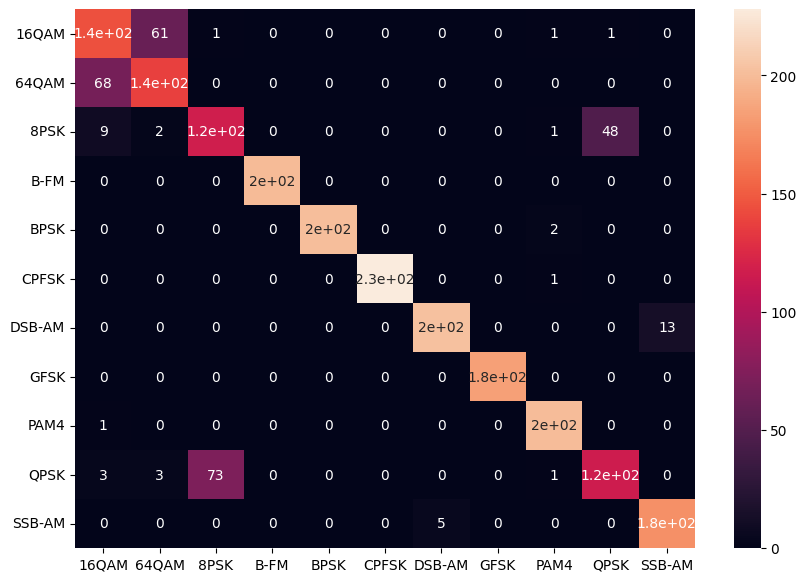

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

snr=0
69/69 [==============================] - 0s 4ms/step
############ SNR=0
Overall test accuracy: 0.49772727272727274
16QAM test accuracy: 0.09090909090909091
64QAM test accuracy: 0.2
8PSK test accuracy: 0.1630901287553648
B-FM test accuracy: 0.933649289099526
BPSK test accuracy: 0.38190954773869346
CPFSK test accuracy: 0.844559585492228
DSB-AM test accuracy: 0.73
GFSK test accuracy: 0.9627659574468085
PAM4 test accuracy: 0.4117647058823529
QPSK test accuracy: 0.21666666666666667
SSB-AM test accuracy: 0.5625
snr=5
69/69 [==============================] - 0s 3ms/step
############ SNR=5
Overall test accuracy: 0.6522727272727272
16QAM test accuracy: 0.33175355450236965
64QAM test accuracy: 0.3386243386243386
8PSK test accuracy: 0.34673366834170855
B-FM test accuracy: 0.9900497512437811
BPSK test accuracy: 0.6559139784946236
CPFSK test accuracy: 0.9073170731707317
DSB-AM test accuracy: 0.7119565217391305
GFSK test accuracy: 0.9907407407407407
PAM4 test accuracy: 0.7075471698113207
QPSK 

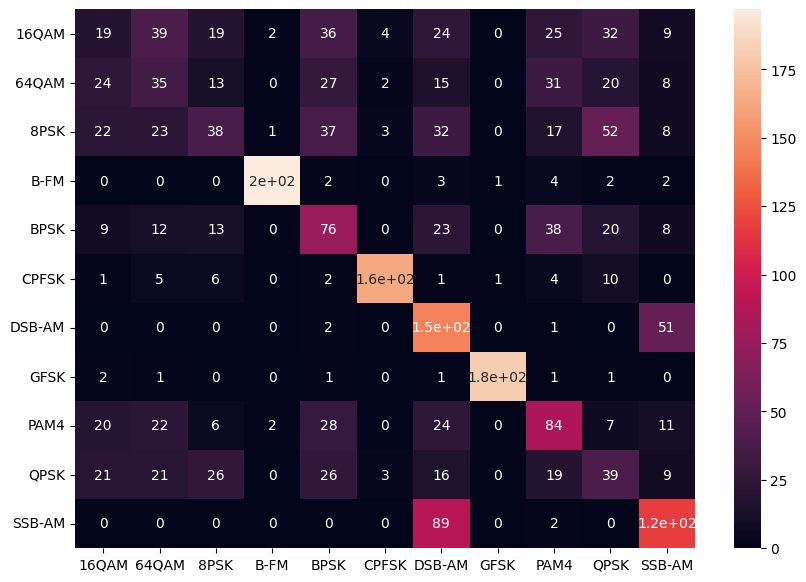

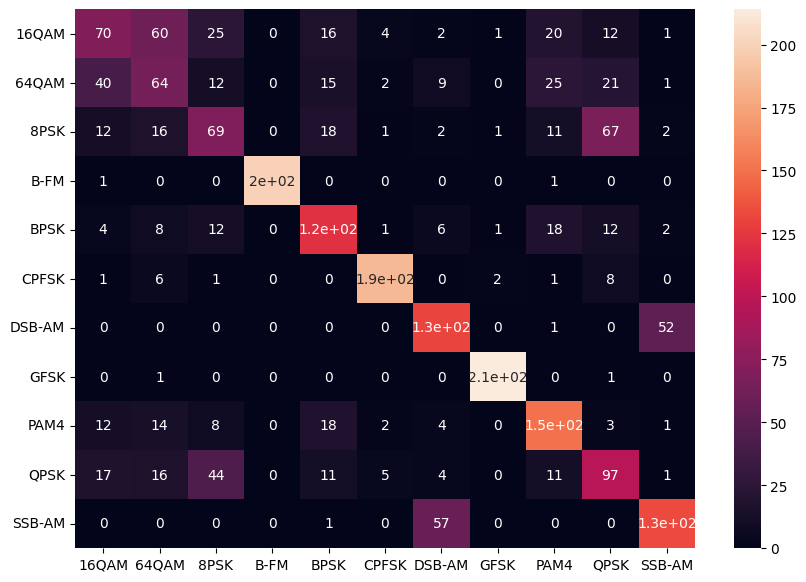

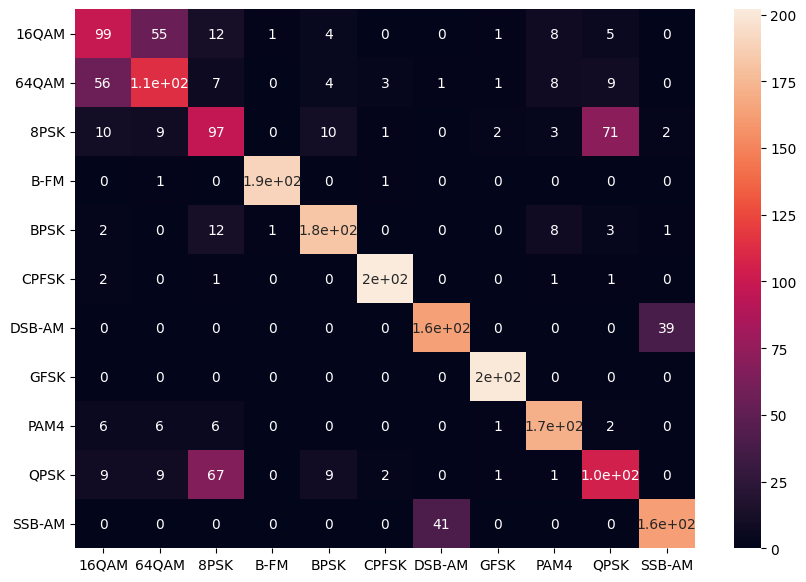

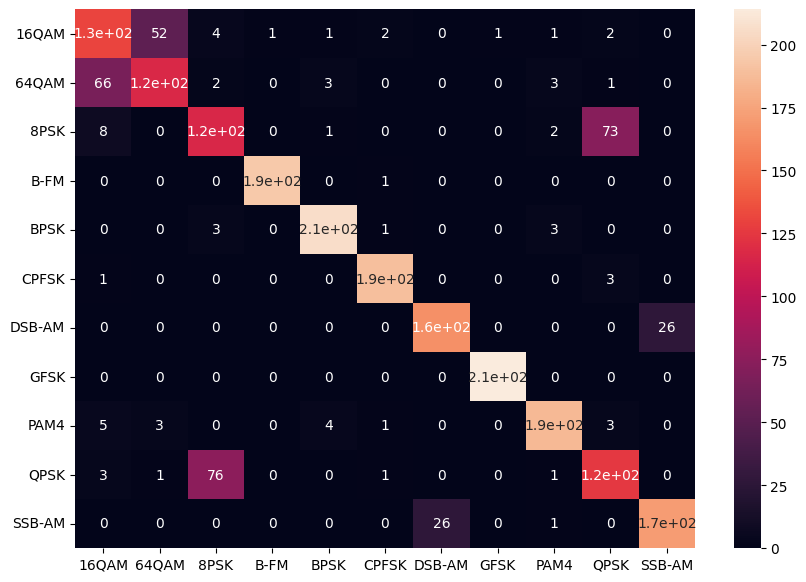

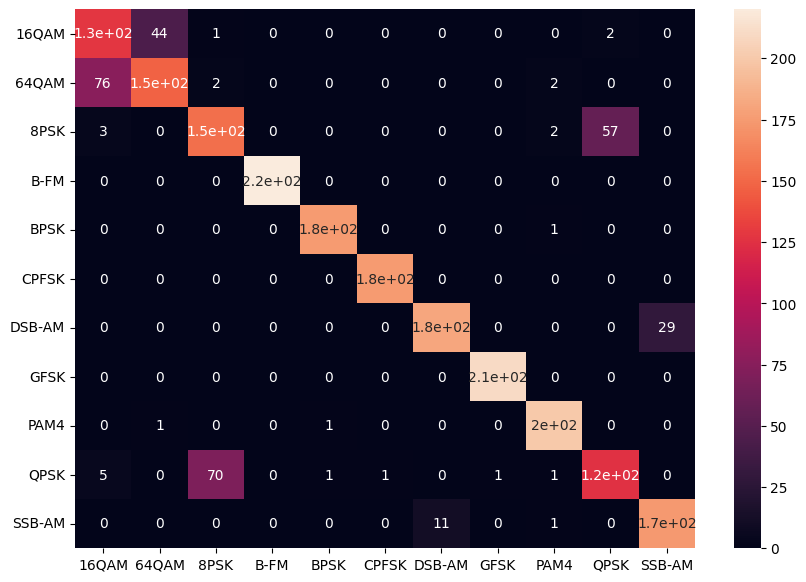

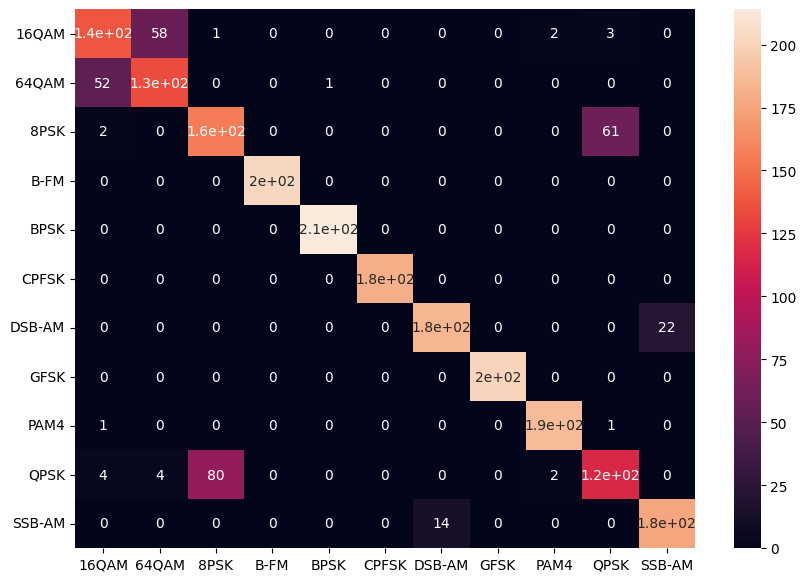

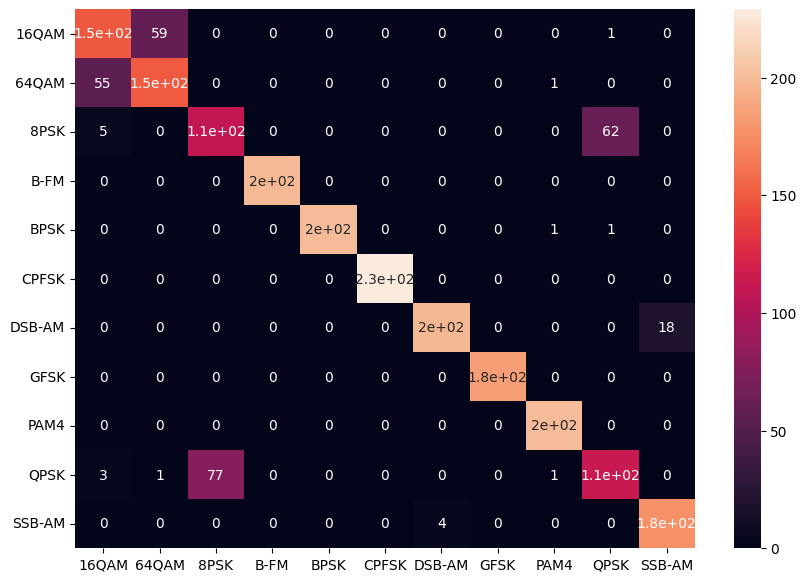

In [54]:
for snr in snrs:
    print(f"snr={snr}")
    test_labels_cur, test_data_cur = snr_to_labels_data_test[snr]
    pred_cur = model.predict(test_data_cur)

    print(f"############ SNR={snr}")
    pred_labels_cur = np.argmax(pred_cur, axis=1)
    print(f"Overall test accuracy: {accuracy_score(test_labels_cur, pred_labels_cur)}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(test_labels_cur == ci)[0]
        cur_test_labels = test_labels_cur[class_indecies]
        cur_pred_labels = pred_labels_cur[class_indecies]
        print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
    cm = confusion_matrix(y_true=test_labels_cur, y_pred=pred_labels_cur)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


In [21]:
def load_test_snr_data(snr):
    test_path = f"/development/download/train_data_SIMC1_2k_SNR_0-30/train_data_SIMC1_2k_SNR_{snr}"
    test_labels_cur, test_data_cur = load_data_simc_v1(classes=modulations, path=Path(test_path), model_dtype=MODEL_DATA_TYPE)
    pred_cur = model.predict(test_data_cur)

    print(f"############ SNR={snr}")
    pred_labels_cur = np.argmax(pred_cur, axis=1)
    print(f"Overall test accuracy: {accuracy_score(test_labels_cur, pred_labels_cur)}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(test_labels_cur == ci)[0]
        cur_test_labels = test_labels_cur[class_indecies]
        cur_pred_labels = pred_labels_cur[class_indecies]
        print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
    cm = confusion_matrix(y_true=test_labels_cur, y_pred=pred_labels_cur)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


In [ ]:
import tools.data
importlib.reload(tools.data)
from tools.data import load_data_simc_v1

test_path = "/development/download/train_data_SIMC1_SNR_30_10k/"
test_labels_cur, test_data_cur = load_data_simc_v1(classes=modulations, path=Path(test_path), model_dtype=MODEL_DATA_TYPE, max_frames_per_mod=1000)
pred_cur = model.predict(test_data_cur)
pred_labels_cur = np.argmax(pred_cur, axis=1)


[debug] Loaded train data with size 11275264 in 6.481863021850586s
345/345 [==============================] - 2s 5ms/step


(11011,)
(11011,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Overall test accuracy: 0.49477794932340385
16QAM test accuracy: 0.002997002997002997
64QAM test accuracy: 0.998001998001998
8PSK test accuracy: 0.0
B-FM test accuracy: 1.0
BPSK test accuracy: 0.4965034965034965
CPFSK test accuracy: 0.995004995004995
DSB-AM test accuracy: 0.4075924075924076
GFSK test accuracy: 0.005994005994005994
PAM4 test accuracy: 0.15784215784215785
QPSK test accuracy: 0.44455544455544455
SSB-AM test accuracy: 0.9340659340659341


<Axes: >

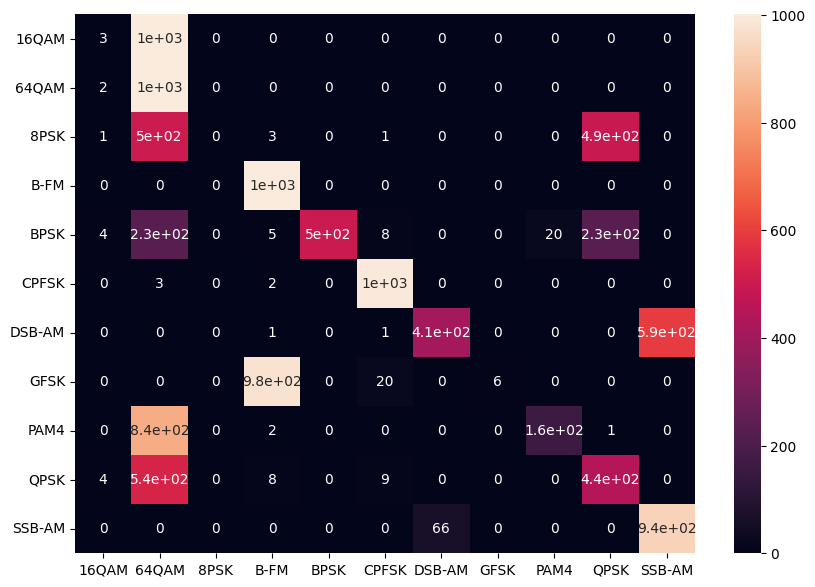

In [ ]:
s = 0
k = 100
print(test_labels_cur.shape)
print(pred_labels_cur.shape)

print(test_labels_cur[s:k+s])
print(pred_labels_cur[s:k+s])

print(f"Overall test accuracy: {accuracy_score(test_labels_cur, pred_labels_cur)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels_cur == ci)[0]
    cur_test_labels = test_labels_cur[class_indecies]
    cur_pred_labels = pred_labels_cur[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels_cur, y_pred=pred_labels_cur)
df_cm = pd.DataFrame(cm, index = modulations,
                columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# load_test_snr_data(30)

[debug] Loaded train data with size 22528000 in 3.5646767616271973s
688/688 [==============================] - 3s 4ms/step
############ SNR=0
Overall test accuracy: 0.3422272727272727
16QAM test accuracy: 0.017
64QAM test accuracy: 0.0
8PSK test accuracy: 0.375
B-FM test accuracy: 0.191
BPSK test accuracy: 0.7205
CPFSK test accuracy: 0.213
DSB-AM test accuracy: 0.9645
GFSK test accuracy: 0.981
PAM4 test accuracy: 0.195
QPSK test accuracy: 0.0
SSB-AM test accuracy: 0.1075
[debug] Loaded train data with size 22528000 in 14.718646049499512s
688/688 [==============================] - 3s 5ms/step
############ SNR=5
Overall test accuracy: 0.5246363636363637
16QAM test accuracy: 0.2785
64QAM test accuracy: 0.0
8PSK test accuracy: 0.7215
B-FM test accuracy: 0.506
BPSK test accuracy: 0.767
CPFSK test accuracy: 0.6025
DSB-AM test accuracy: 0.9565
GFSK test accuracy: 0.986
PAM4 test accuracy: 0.637
QPSK test accuracy: 0.018
SSB-AM test accuracy: 0.298
[debug] Loaded train data with size 22528000 

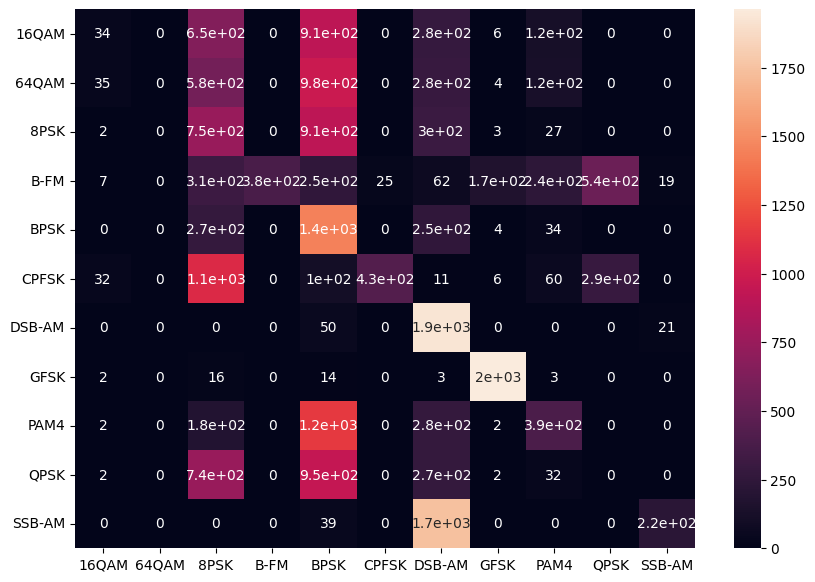

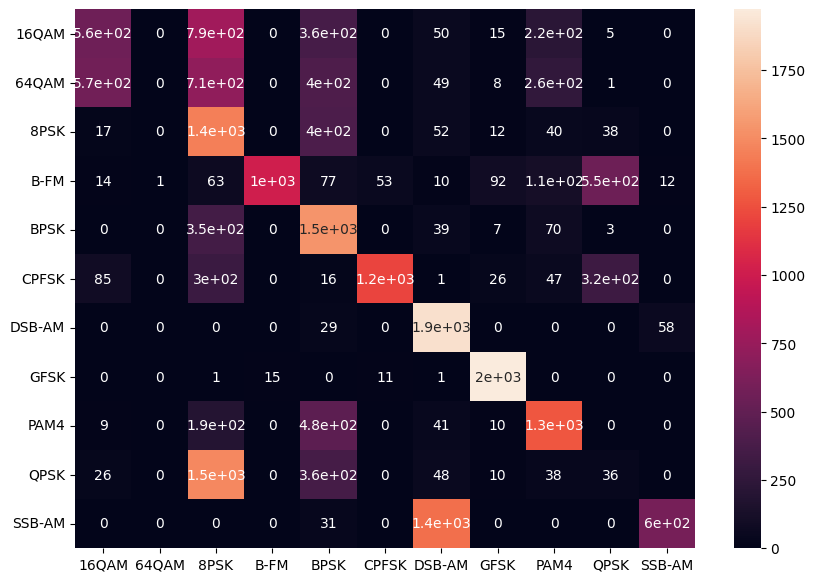

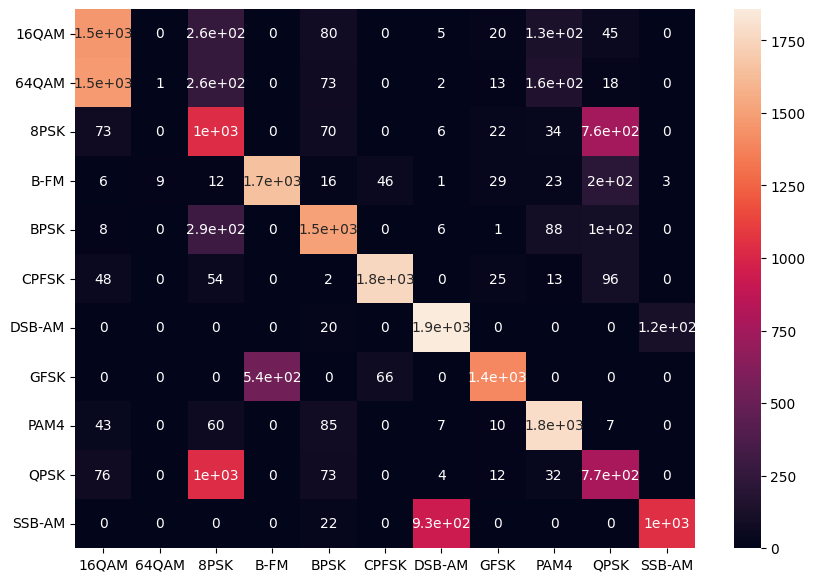

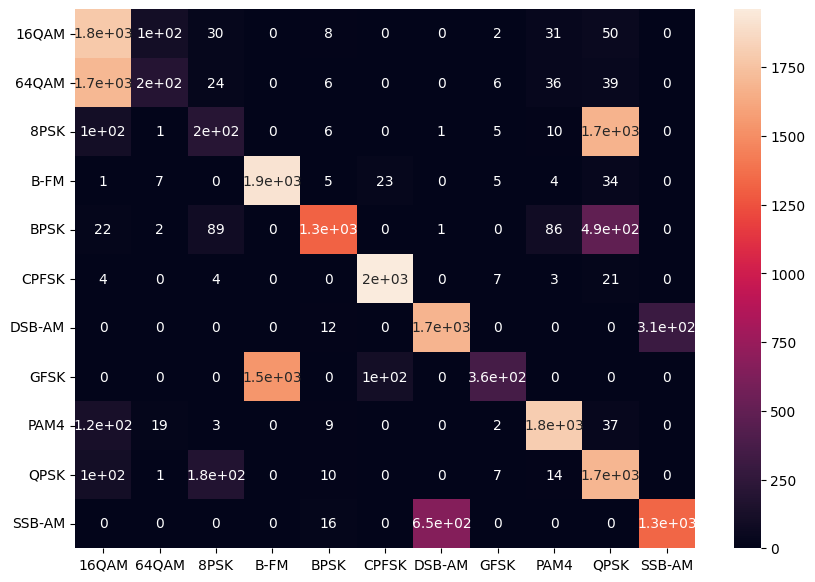

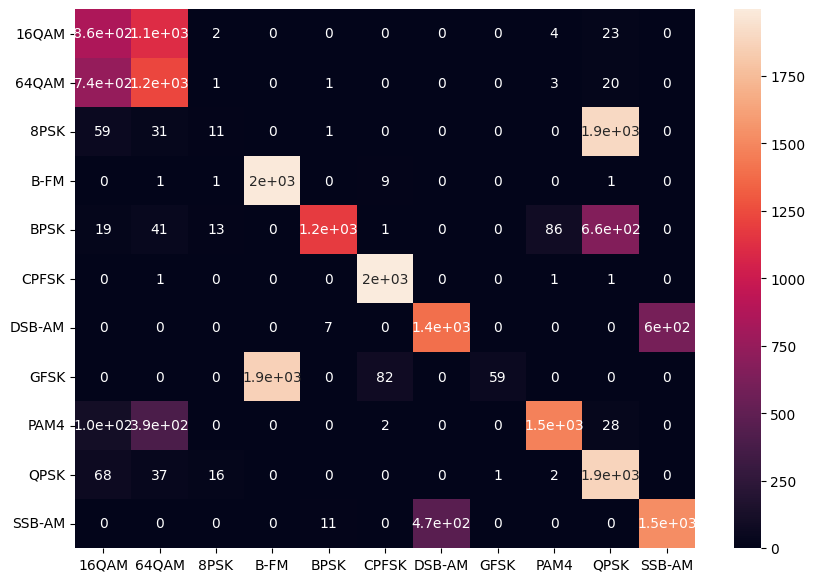

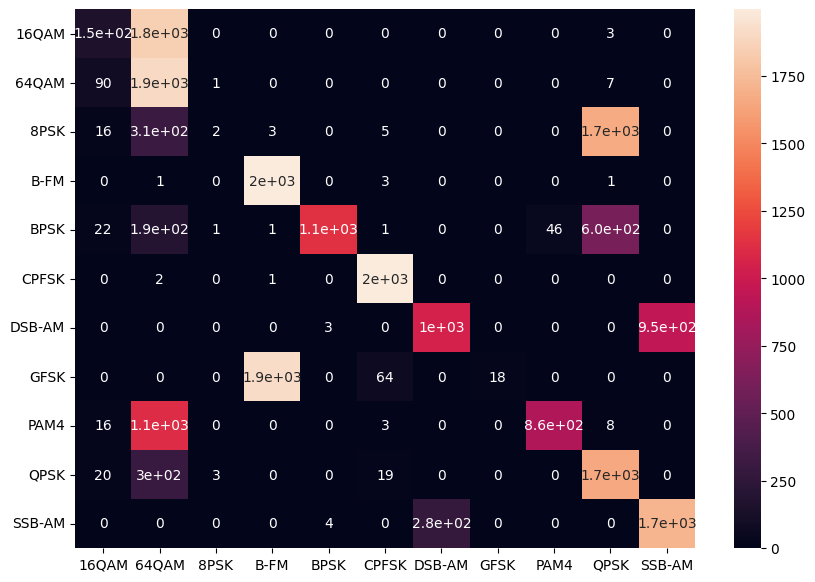

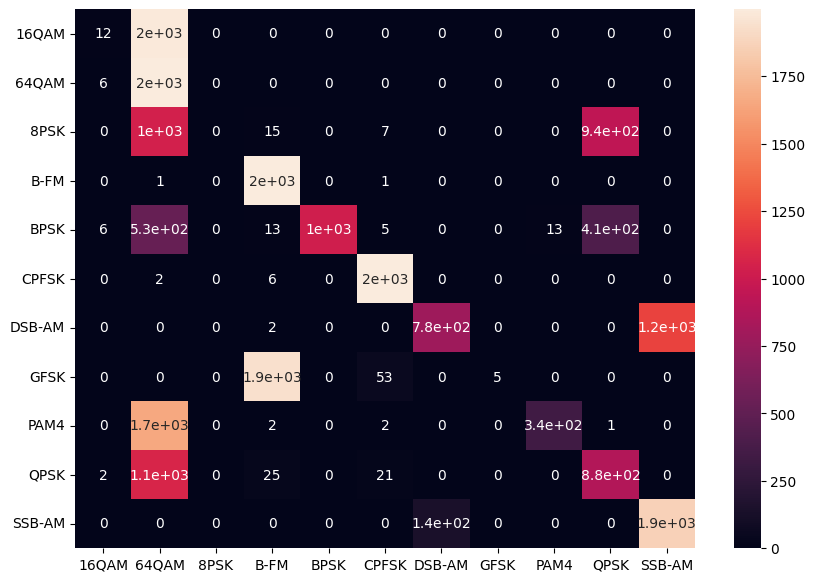

In [ ]:
for snr in (0, 5, 10, 15, 20, 25, 30):
    load_test_snr_data(snr)


[debug] Loaded train data with size 22528000 in 3.5506958961486816s
688/688 [==============================] - 2s 3ms/step
############ SNR=25
Overall test accuracy: 0.5674545454545454
16QAM test accuracy: 0.0765
64QAM test accuracy: 0.951
8PSK test accuracy: 0.001
B-FM test accuracy: 0.9975
BPSK test accuracy: 0.5675
CPFSK test accuracy: 0.9985
DSB-AM test accuracy: 0.524
GFSK test accuracy: 0.009
PAM4 test accuracy: 0.43
QPSK test accuracy: 0.829
SSB-AM test accuracy: 0.858
[debug] Loaded train data with size 22528000 in 3.52494215965271s
688/688 [==============================] - 3s 5ms/step
############ SNR=30
Overall test accuracy: 0.49472727272727274
16QAM test accuracy: 0.006
64QAM test accuracy: 0.997
8PSK test accuracy: 0.0
B-FM test accuracy: 0.999
BPSK test accuracy: 0.5115
CPFSK test accuracy: 0.996
DSB-AM test accuracy: 0.391
GFSK test accuracy: 0.0025
PAM4 test accuracy: 0.1715
QPSK test accuracy: 0.4375
SSB-AM test accuracy: 0.93


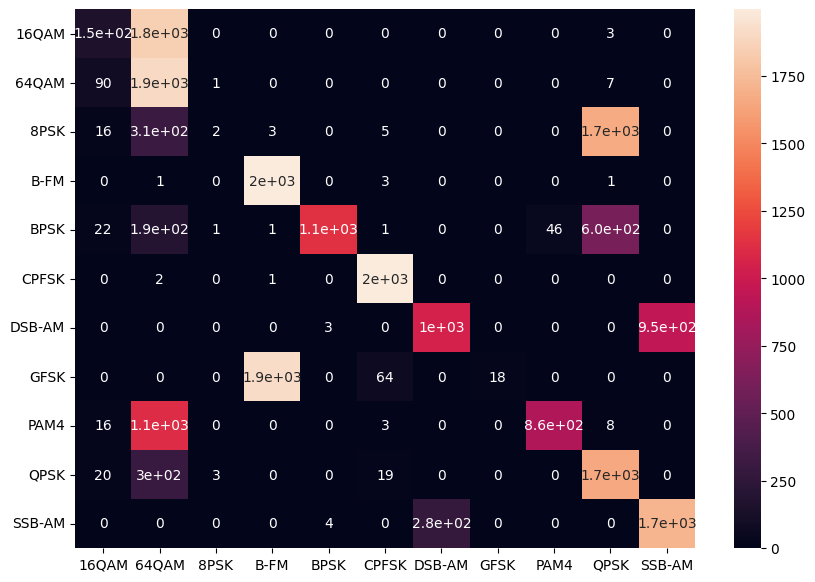

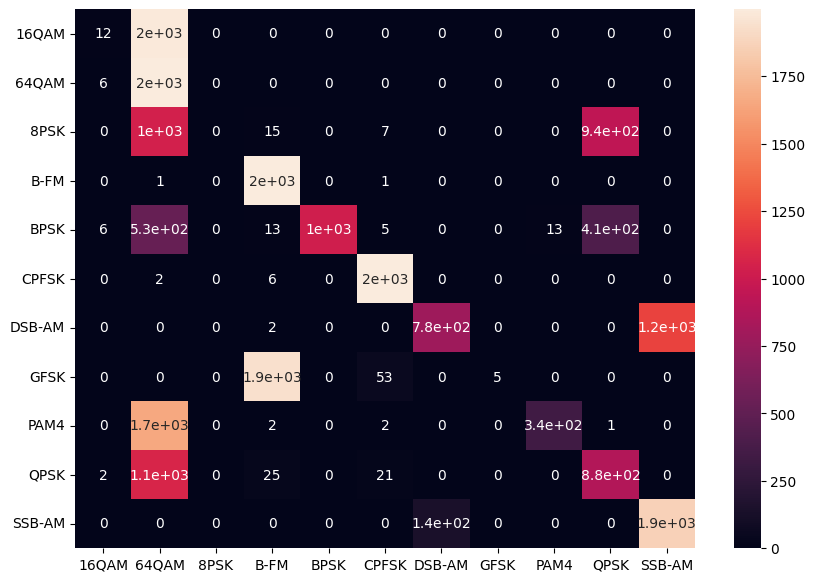

In [ ]:
load_test_snr_data(25)
load_test_snr_data(30)

### Mode deployment

In [22]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_2_radioML_a_RADIO_ML_A/model/assets


INFO:tensorflow:Assets written to: models_simc_2_radioML_a_RADIO_ML_A/model/assets


In [ ]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

396436

In [ ]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [ ]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


114448

In [ ]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[2 8 3 2 0 1 2 7 7 4]
[9 8 3 9 0 0 2 7 7 4]


Overall test accuracy: 0.8470909090909091
16QAM test accuracy: 0.7524752475247525
64QAM test accuracy: 0.6149312377210217
8PSK test accuracy: 0.8263888888888888
B-FM test accuracy: 0.9889224572004028
BPSK test accuracy: 0.994692144373673
CPFSK test accuracy: 0.9968051118210862
DSB-AM test accuracy: 0.9408284023668639
GFSK test accuracy: 1.0
PAM4 test accuracy: 0.9841269841269841
QPSK test accuracy: 0.32146389713155293
SSB-AM test accuracy: 0.9206049149338374


<Axes: >

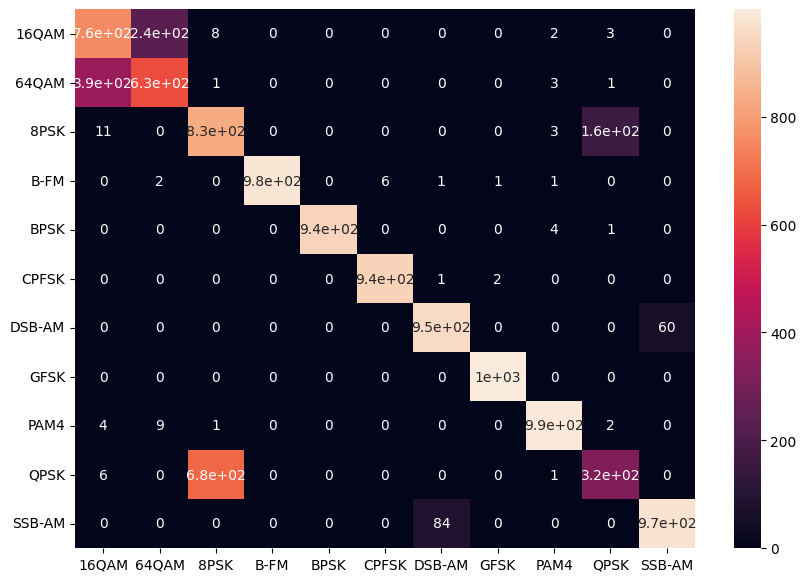

In [ ]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.        0.        0.5703125 0.        0.        0.        0.
 0.        0.        0.4296875 0.       ]


In [ ]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=True,
    epsilon=10,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 677.24it/s]

[Warning] proj directory already exists: /development/RISC-V-SIMD-extension-for-the-AI-workload/proj/simc_2
